# Выбор глубины и числа фильтров для модели

## Содержание
* [Постановка задачи](#Постановка задачи)
* [Исследуемые параметры](#Исследуемые параметры)
* [Область значений параметра](#Область значений параметра)
* [Измеряемые характеристики](#Измеряемые характеристики)
* [Определение датасета](#Определение датасета)
* [Создание модели](#Создание модели)
* [Создание объекта research](#Создание объекта research)
* [Выводы](#Выводы)

## Постановка задачи
Выбрать параметры архитектуры CNN, классифицирующей  датасет MNIST.

## Исследуемые параметры
Глубина сети - число building block-ов заданной конфигурации, число фильтров конволюций.

## Область значений параметра
Число блоков: [2, 3, 4, 5].

Число фильтров в первой конволюции: [16, 32, 64].

## Измеряемые характеристики

Метрика accuracy на тестовой части датасета MNIST.

## Определение датасета
Создание датасета и, при необходимости, загрузка исходных данных.

In [61]:
!nvidia-smi

Fri Mar  1 11:20:06 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.78       Driver Version: 410.78       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   31C    P8    10W / 180W |   7954MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
| 27%   32C    P8    11W / 180W |     10MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
%env CUDA_VISIBLE_DEVICES=1, 5, 6, 7

env: CUDA_VISIBLE_DEVICES=1, 5, 6, 7


In [3]:
import sys
import os
sys.path.insert(0, os.path.join(".."))

In [4]:
from copy import deepcopy
from itertools import combinations

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from radial.batchflow import Dataset, FilesIndex, Pipeline, R, B, V, C, action, inbatch_parallel
from radial.batchflow.models.tf import TFModel
from radial.batchflow.models.tf.layers import conv_block

from radial.batchflow.research import Research, Option
from radial.batchflow.research.research import Executable

from radial.core import RadialBatch, RadialImagesBatch
from radial.core.radial_batch_tools import get_mape, get_mape30, save_model, get_ape

from research_utils import *
plt.style.use('ggplot')
%matplotlib inline

In [5]:
ds_train = Dataset(FilesIndex(path="./data_splited/train_isol/*"), batch_class=RadialBatch)
ds_test = Dataset(FilesIndex(path="./data_splited/test_isol/*"), batch_class=RadialBatch)

## Обход датасета

- Отдельно выделяем корневой пайплайн, который будет общим для разных конфигураций модели.
- Определяем размер батча (16), фиксируем обход датасета, зафиксировав seed

In [6]:
BATCH_SIZE = 16
GRID_SIZE = 200

In [7]:
def log(*args):
    return np.array(list(map(np.log10, args)))

load_ppl = (Pipeline()
                .init_variable('loss_history_dict', init_on_each_run=0)
                .hard_negative_sampling(statistics_name='loss_history_dict', fraction=0.33)
                .load(fmt='npz')
                .drop_negative()
                .apply_transform(log, src=['time', 'derivative', 'target'], dst=['log_time', 'log_derivative', 'log_target'])
                .normalize(src=['log_time', 'log_derivative'], dst=['log_norm_time', 'log_norm_derivative'],\
                           dst_range=[None, 'derivative_range'])
                .normalize(src='log_target', dst='log_norm_target', src_range='derivative_range')
                .expand_dims(src='log_norm_target')
                .make_grid_data(src=['log_norm_time', 'log_norm_derivative'], dst=['log_norm_time_grid', 'log_norm_derivative_grid'],
                                grid_size=GRID_SIZE)
                .make_array(src='log_norm_derivative_grid', dst='derivative_grid')
           )

In [8]:
train_root = (load_ppl
                .run(BATCH_SIZE, shuffle=True, drop_last=True, n_epochs=None, lazy=True) << ds_train)
              
test_root = (load_ppl
                .run(BATCH_SIZE, shuffle=True, n_epochs=1, drop_last=True, lazy=True) << ds_test)

## Создание модели

Создадим небольшую CNN, передав параметры слоев в `model_config`. 
Параметры, которые будут варьироваться определяем как `C('parameter_name')`.

Мы варьируем `n_blocks` и `n_filters` - начальное число фильтров в первой конволюции. В каждой последующей конволюции число фильтров увеличивается в два раза.

Каждый блог имеет фиксированный `layout='cpna'`.

Также фиксируем алгоритм оптимизатора. Используем оптимизатор `Adam` (tf.train.AdamOptimizer) т.к. он часто используется в качестве бейзлайна.



In [9]:
class ConvModel(TFModel):
    def body(cls, inputs, **kwargs):
        x = inputs
        for i in range(kwargs['n_blocks']):
            x = conv_block(x, kwargs['layout'], filters=2 ** i * kwargs['filters'],
                           kernel_size=kwargs['kernel_size'], strides=2, pool_strides=2, name='block_' + str(i))
        return x

In [10]:
model_config = {
    'inputs': dict(signals=dict(shape=(GRID_SIZE, 1)),
                             labels={'shape': (1), 'name': 'targets'}),
    'body': dict(n_blocks=C('n_blocks'), layout=C('layout'), filters=C('filters'), kernel_size=C('kernel_size')),
    'head': dict(layout='Pf', units=1),
    'initial_block/inputs': 'signals',
    'loss': 'mse',
    'optimizer': ('MomentumOptimizer', {'learning_rate': 0.001, 'momentum': 0.5})}

Создадим пайплайн для обучения и теста.

In [11]:
train_template = (load_ppl +
                  Pipeline()
                 .init_variable('loss')
                 .init_variable('mean_loss_history', init_on_each_run=list)
                 .init_variable('loss_history', init_on_each_run=0)
                 .init_model('dynamic', ConvModel, 'model', config=model_config)
                 .train_model('model', fetches=['loss', 'ConvModel/mean_squared_error/SquaredDifference:0'],
                           feed_dict={'signals': B('derivative_grid'),
                                      'labels': B('log_norm_target')}, 
                           save_to=[V('loss'), V('loss_history')], mode='w')
                 .update_variable('mean_loss_history', V('loss'), mode='a')
                 .update_loss_history_dict()
                 )

test_template = (load_ppl + 
                 Pipeline()
                  .init_variable('loss', init_on_each_run=0)
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_variable('targets', init_on_each_run=list)
                  .init_variable('predictions', init_on_each_run=list)
                  .import_model('model', C('import_from'))
                  .predict_model('model', fetches=['loss', 'predictions'],
                               feed_dict={'signals': B('derivative_grid'),
                                          'labels': B('log_norm_target')},
                               save_to=[V('loss'), B('predictions')], mode='w')
                  .update_variable('loss_history', V('loss'), mode='a')
                  .denormalize(src='predictions', dst='denorm_predictions',
                               src_range='derivative_range')
                  .update_variable('targets', B('log_target'), mode='e')
                  .update_variable('predictions', B('denorm_predictions'), mode='e')
                )

train_ppl = train_root + train_template
test_ppl = test_root + test_template

## Создание объекта research

Зададим параметры для запусков research. Добавим в research подсчет функции `get_accuracy`, которая будет выполнена каждые 50 итераций, получив результаты работы пайплайна c именем `test`

## Подбор размера ядра

In [12]:
opts = Option('n_blocks', [4]) * Option('layout', ['cna']) * Option('filters', [16]) * Option('kernel_size', [3, 7, 13, 19, 23])

research = (Research()
            .pipeline(train_ppl, variables='loss', name='train')
            .pipeline(test_ppl, variables='loss', name='test', execute='%5',
                      run=True, import_from='train')
            .grid(opts)
            .function(get_mape, returns='metrics', name='test_mape',
                      execute='%5', pipeline='test')
            .function(get_mape30, returns='metrics', name='test_mape30',
                      execute='%5', pipeline='test')
            .function(get_ape, returns='metrics', name='test_ape',
                     execute=-1, pipeline='test')
            .function(save_model, execute=-1, pipeline='train',
                      model_name='model', path='parameters_est_models/'))

In [13]:
NUM_REPEAT = 3
NUM_ITERS = 800
research_name = 'kernel_size_4_layers'

In [ ]:
research.run(n_reps=NUM_REPEAT, n_iters=NUM_ITERS, name=research_name, progress_bar=True)

Research kernel_size_4_layers is starting...


  0%|          | 0/12000 [00:00<?, ?it/s]

Distributor has 15 jobs with 800 iterations. Totally: 12000
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


  7%|▋         | 800/12000 [08:51<2:03:57,  1.51it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 13%|█▎        | 1600/12000 [17:42<1:55:07,  1.51it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 20%|██        | 2400/12000 [26:33<1:46:15,  1.51it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 27%|██▋       | 3200/12000 [35:29<1:37:36,  1.50it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 33%|███▎      | 4000/12000 [44:10<1:28:21,  1.51it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 40%|████      | 4800/12000 [53:03<1:19:34,  1.51it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 42%|████▏     | 5012/12000 [55:25<1:17:16,  1.51it/s]

## Обработка результатов:

In [19]:
len(ds_train.indices)

311

In [20]:
2000 * 16 / 311

102.89389067524115

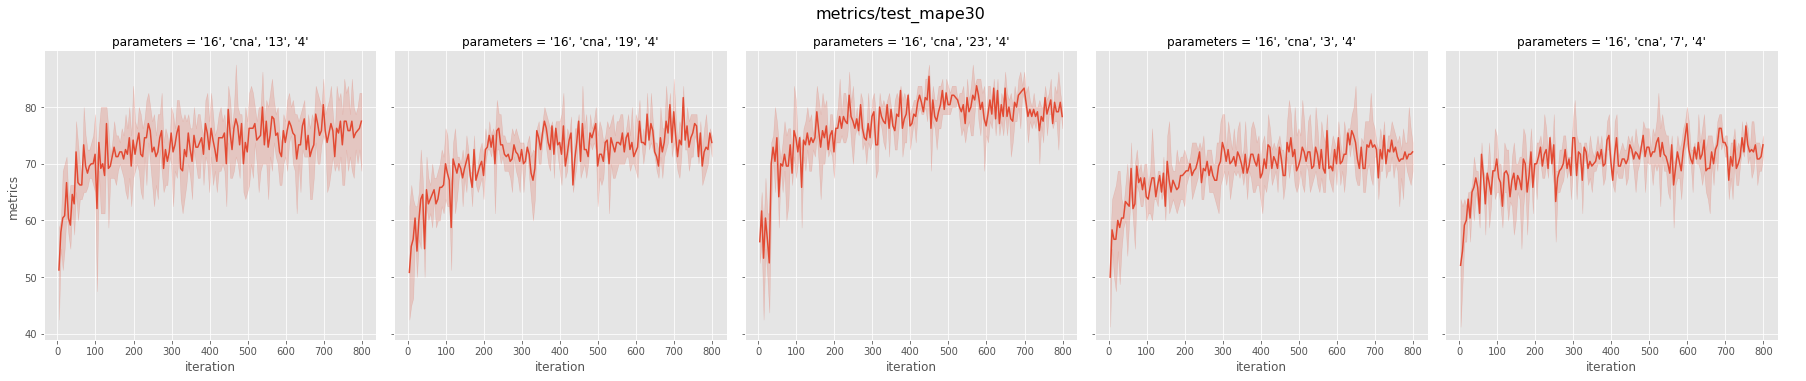

In [15]:
draw_history(research=research, names=['test_mape30'], types_var=['metrics'], cross_val=None, aggr=False, iter_start=1)

In [17]:
opts = Option('n_blocks', [6]) * Option('layout', ['cna', 'cpna']) * Option('filters', [16]) * Option('kernel_size', [23]) + \
        Option('n_blocks', [3]) * Option('layout', ['Rcnacn+a']) * Option('filters', [16]) * Option('kernel_size', [23])

research = (Research()
            .pipeline(train_ppl, variables='loss', name='train')
            .pipeline(test_ppl, variables='loss', name='test', execute='%5',
                      run=True, import_from='train')
            .grid(opts)
            .function(get_mape, returns='metrics', name='test_mape',
                      execute='%5', pipeline='test')
            .function(get_mape30, returns='metrics', name='test_mape30',
                      execute='%5', pipeline='test')
            .function(get_ape, returns='metrics', name='test_ape',
                     execute=-1, pipeline='test')
            .function(save_model, execute=-1, pipeline='train',
                      model_name='model', path='parameters_est_models/'))

In [ ]:
research.run(n_reps=NUM_REPEAT, n_iters=NUM_ITERS, name='layout', progress_bar=True)

Research layout is starting...


  0%|          | 0/7200 [00:00<?, ?it/s]

Distributor has 9 jobs with 800 iterations. Totally: 7200
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 11%|█         | 800/7200 [08:25<1:07:27,  1.58it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 22%|██▏       | 1600/7200 [15:53<55:38,  1.68it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 33%|███▎      | 2400/7200 [15:54<31:49,  2.51it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 44%|████▍     | 3200/7200 [23:21<29:11,  2.28it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 56%|█████▌    | 4000/7200 [30:31<24:25,  2.18it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 67%|██████▋   | 4800/7200 [30:32<15:16,  2.62it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 78%|███████▊  | 5600/7200 [39:16<11:13,  2.38it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 88%|████████▊ | 6335/7200 [46:03<06:17,  2.29it/s]

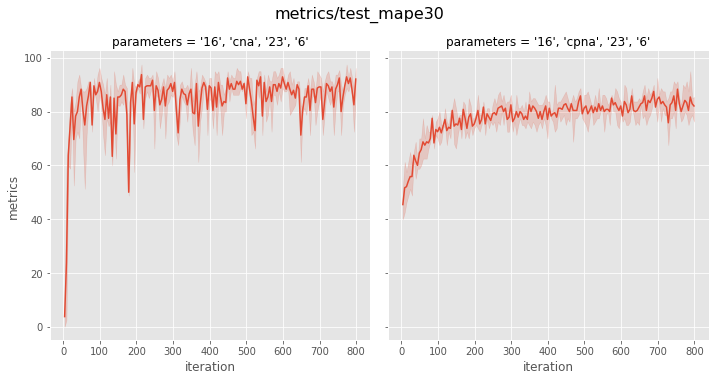

In [19]:
draw_history(research=research, names=['test_mape30'], types_var=['metrics'], cross_val=None, aggr=False, iter_start=1)

In [24]:
opts = Option('n_blocks', [3, 4, 6, 8]) * Option('layout', ['cna']) * Option('filters', [16, 32, 64]) * Option('kernel_size', [23])

research = (Research()
            .pipeline(train_ppl, variables='loss', name='train')
            .pipeline(test_ppl, variables='loss', name='test', execute='%5',
                      run=True, import_from='train')
            .grid(opts)
            .function(get_mape, returns='metrics', name='test_mape',
                      execute='%5', pipeline='test')
            .function(get_mape30, returns='metrics', name='test_mape30',
                      execute='%5', pipeline='test')
            .function(get_ape, returns='metrics', name='test_ape',
                     execute=-1, pipeline='test')
            .function(save_model, execute=-1, pipeline='train',
                      model_name='model', path='parameters_est_models/'))

In [25]:
NUM_REPEAT = 3
NUM_ITERS = 1200
research_name = 'depth_width'

In [ ]:
research.run(n_reps=NUM_REPEAT, n_iters=NUM_ITERS, name=research_name, progress_bar=True)

Research layout_2 is starting...


  0%|          | 0/43200 [00:00<?, ?it/s]

Distributor has 36 jobs with 1200 iterations. Totally: 43200
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


  3%|▎         | 1200/43200 [09:54<5:46:44,  2.02it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


  6%|▌         | 2400/43200 [19:14<5:26:58,  2.08it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


  8%|▊         | 3600/43200 [28:18<5:11:20,  2.12it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 11%|█         | 4800/43200 [38:51<5:10:50,  2.06it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 14%|█▍        | 6000/43200 [49:29<5:06:49,  2.02it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 17%|█▋        | 7200/43200 [58:48<4:54:04,  2.04it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 19%|█▉        | 8400/43200 [1:08:18<4:43:01,  2.05it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 22%|██▏       | 9600/43200 [1:18:05<4:33:19,  2.05it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 25%|██▌       | 10800/43200 [1:31:26<4:34:19,  1.97it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 27%|██▋       | 11513/43200 [1:39:40<4:34:21,  1.92it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 28%|██▊       | 12000/43200 [1:44:53<4:32:42,  1.91it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 29%|██▉       | 12592/43200 [1:58:26<4:47:54,  1.77it/s]

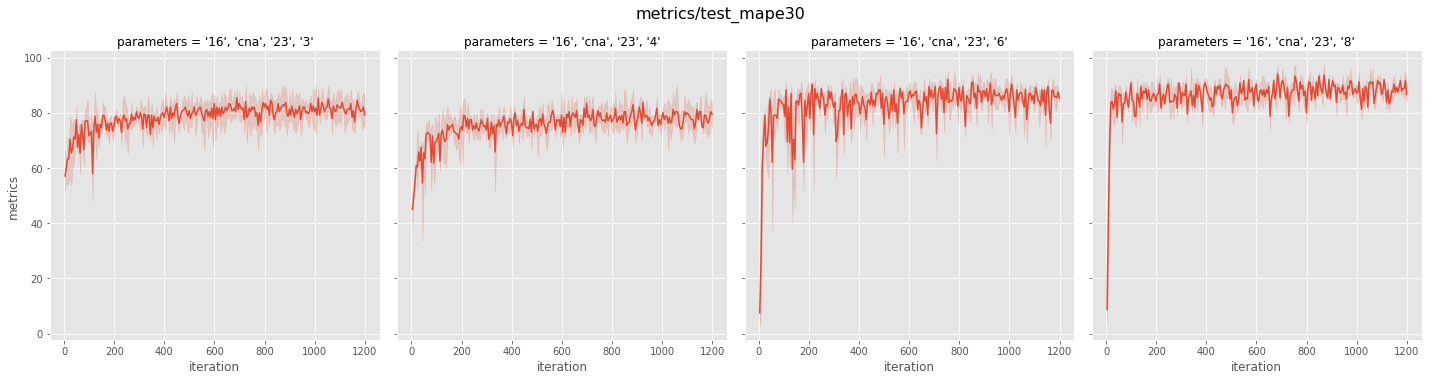

In [36]:
draw_history(research=research, names=['test_mape30'], types_var=['metrics'], cross_val=None, aggr=False, iter_start=1,\
             draw_dict=dict(layout='cna', filters='16', kernel_size='23'))

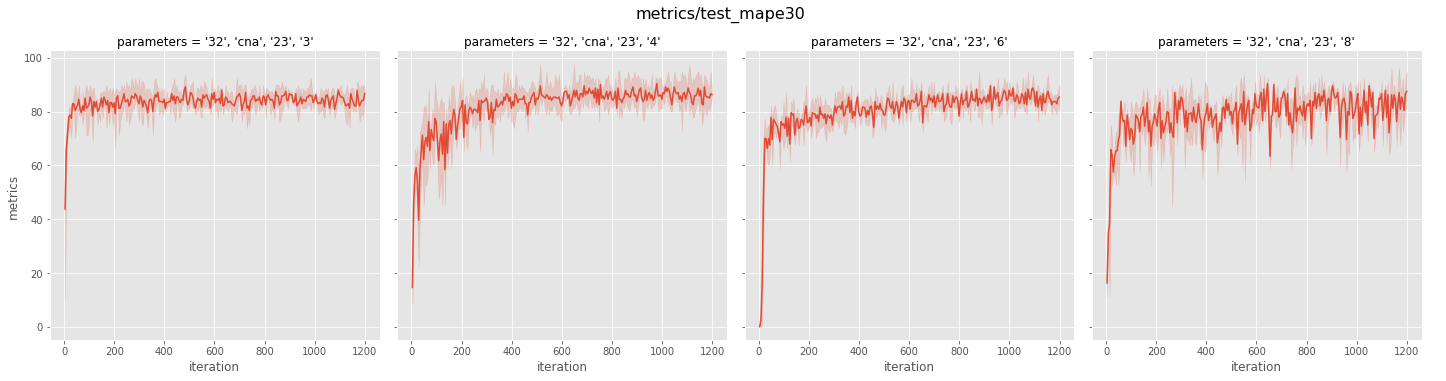

In [40]:
draw_history(research=research, names=['test_mape30'], types_var=['metrics'], cross_val=None, aggr=False, iter_start=1,\
             draw_dict=dict(layout='cna', filters='32', kernel_size='23'))

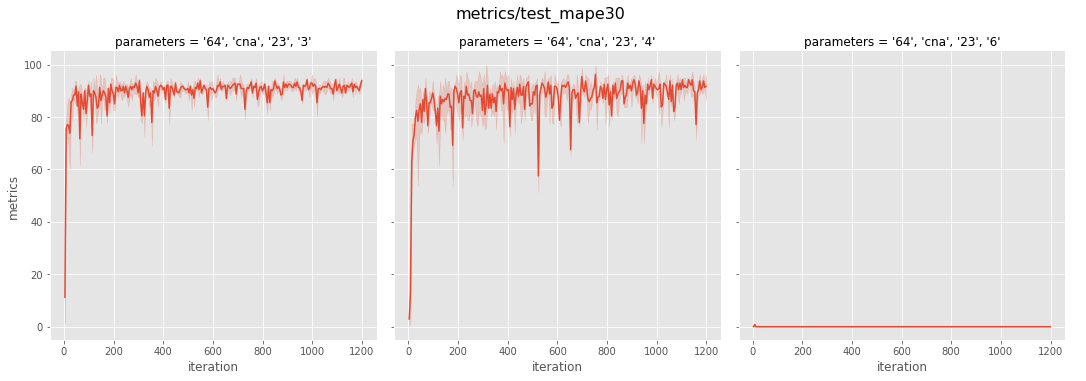

In [41]:
draw_history(research=research, names=['test_mape30'], types_var=['metrics'], cross_val=None, aggr=False, iter_start=1,\
             draw_dict=dict(layout='cna', filters='64', kernel_size='23'))

In [50]:
print_results(research=research, names=['test_mape30'], types_var=['metrics'], n_last=1)

╒════════════════════════╤═══════════════╕
│ params                 │   test_mape30 │
╞════════════════════════╪═══════════════╡
│ '32', 'cna', '23', '8' │       87.5    │
├────────────────────────┼───────────────┤
│ '32', 'cna', '23', '3' │       86.6667 │
├────────────────────────┼───────────────┤
│ '32', 'cna', '23', '6' │       85.4167 │
├────────────────────────┼───────────────┤
│ '32', 'cna', '23', '4' │       86.25   │
├────────────────────────┼───────────────┤
│ '16', 'cna', '23', '6' │       85.4167 │
├────────────────────────┼───────────────┤
│ '16', 'cna', '23', '4' │       79.5833 │
├────────────────────────┼───────────────┤
│ '64', 'cna', '23', '6' │        0      │
├────────────────────────┼───────────────┤
│ '16', 'cna', '23', '8' │       86.6667 │
├────────────────────────┼───────────────┤
│ '64', 'cna', '23', '4' │       91.6667 │
├────────────────────────┼───────────────┤
│ '16', 'cna', '23', '3' │       79.1667 │
├────────────────────────┼───────────────┤
│ '64', 'cn

In [43]:
print_results(research=research, names=['test_mape30'], types_var=['metrics'])

╒════════════════════════╤═══════════════╕
│ params                 │   test_mape30 │
╞════════════════════════╪═══════════════╡
│ '32', 'cna', '23', '8' │       81.9833 │
├────────────────────────┼───────────────┤
│ '32', 'cna', '23', '3' │       84.3417 │
├────────────────────────┼───────────────┤
│ '32', 'cna', '23', '6' │       84.65   │
├────────────────────────┼───────────────┤
│ '32', 'cna', '23', '4' │       86.1167 │
├────────────────────────┼───────────────┤
│ '16', 'cna', '23', '6' │       85.7292 │
├────────────────────────┼───────────────┤
│ '16', 'cna', '23', '4' │       78.1583 │
├────────────────────────┼───────────────┤
│ '64', 'cna', '23', '6' │        0      │
├────────────────────────┼───────────────┤
│ '16', 'cna', '23', '8' │       88.1917 │
├────────────────────────┼───────────────┤
│ '64', 'cna', '23', '4' │       89.9167 │
├────────────────────────┼───────────────┤
│ '16', 'cna', '23', '3' │       81.075  │
├────────────────────────┼───────────────┤
│ '64', 'cn

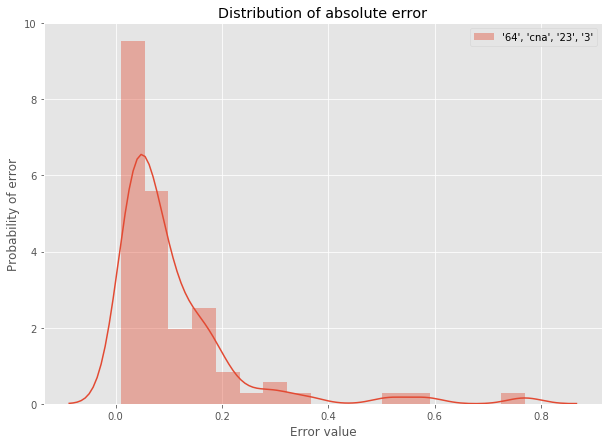

In [55]:
draw_hisogram([research], names='test_ape', type_var='metrics', cross_val=1, draw_dict=dict(layout='cna', n_blocks='3', filters='64', kernel_size='23'))

## Выводы

Судя по графикам test_mape30, можем определить, что лучшей оказалась модель с параметрами n_blocks=3, n_filters=64

Несмотря на то, что выбранная конфигурация модели в среднем оказалась лучше других, полезно, наряду с точечной оценкой, получить распределение метрики по N независимым запускам.

In [62]:
opts = Option('n_blocks', [3]) * Option('layout', ['cna']) * Option('filters', [64]) * Option('kernel_size', [23])

research = (Research()
            .pipeline(train_ppl, variables='loss', name='train')
            .pipeline(test_ppl, variables='loss', name='test', execute='%5',
                      run=True, import_from='train')
            .grid(opts)
            .function(get_mape, returns='metrics', name='test_mape',
                      execute='%5', pipeline='test')
            .function(get_mape30, returns='metrics', name='test_mape30',
                      execute='%5', pipeline='test')
            .function(get_ape, returns='metrics', name='test_ape',
                     execute=-1, pipeline='test')
            .function(save_model, execute=-1, pipeline='train',
                      model_name='model', path='parameters_est_models/'))

In [63]:
NUM_REPEAT = 20
NUM_ITERS = 2000
research_name = 'model_est'

In [ ]:
research.run(n_reps=NUM_REPEAT, n_iters=NUM_ITERS, name=research_name, progress_bar=True)

Research model_est is starting...


  0%|          | 0/40000 [00:00<?, ?it/s]

Distributor has 20 jobs with 2000 iterations. Totally: 40000
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


  2%|▏         | 769/40000 [07:40<6:31:36,  1.67it/s]